In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import scipy.stats
import random
from numpy.random import permutation

from IPython.display import HTML, display

from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import load_workbook

## Field name -- by Vaieties
Maris Piper: 'R21', '582', 'M12', 'Duffy'

Soraya : 'Somerlayton', 'Year 1 trial field', 'Yr 1 variety trial', 'Field', 'Failey 1'

Jelly: 'Franklin', 'Irby Hall Nort', 'Middle Allotement', 'RHP', 'Somerlayton'

Venezia: 'Chanters Hole', 'Hanger Blackdyke', 'Hanger Blackdyke', 'HS2', 'Lovers Pightle', 'TurnPike', 'wortley', 'NSB Trial 1'

Marfona:

Lady Balfour:

Orchestra:



## Defining Functions

In [1303]:
#wb2 = load_workbook('CAI_Rawdata_27.07.18.xlsx')

def load_batch_data(variety_name):
    with open(variety_name+"_TuberData.csv",'r') as csvfile:
        batch_data = pd.read_csv(csvfile)
    return pd.DataFrame(batch_data)

variety_names = ['MarisPiper', 'Jelly','Soraya', 'Venezia','Marfona','Orchestra','LadyBalfour','Orchestra']
variety_dict = {'MarisPiper': ['R21', '582', 'M12', 'Duffy', 'A'],
               'Jelly': ['Franklin', 'Irby Hall Nort',  'RHP', 'Somerlayton'],
               'Soraya': ['Somerlayton', 'Year 1 trial field'],
               'Venezia':['Chanters Hole', 'Hanger Blackdyke', 'Hanger Blackdyke', 'HS2', 'Lovers Pightle', 'TurnPike', 'wortley', 'NSB Trial 1'],
               'Marfona':['APT Farming','APT Farming 2','APT Farming 3','Early Baker','EB Field - Dig 1','EB Field - Dig 2',
                         'Park Farm', 'Salmons' ],
               'LadyBalfour': ['Commercial Crop 1','Commercial Crop 2','Field Sample 1','Field Sample 2','Trial Guard Row 1',
                               'Trial Guard Row 2','Trial Guard Row 3'],
                'Orchestra':['Oxford Field','Plumbs','Water Lane']
        }


def get_traning_testing_data(field,variety):
    df = load_batch_data(variety)

    #field = variety_dict[variety_names[variety_ind]] 
    #print(variety)
    #print(field)
    # defining training dataset
    train_data  = df[df['Type'] != field]
    #defining testing dataset
    test_data  = df[df['Type'] == field]

    train_data = train_data.fillna(0)
    test_data = test_data.fillna(0)

    #split into training and testing input(x) and output (y) data
    fact_toconvert_int = 1000

    bands_train_data = train_data.iloc[:,1].values
    weight_train_data = train_data.iloc[:,5].values*fact_toconvert_int
    weight_train_data  = weight_train_data.astype(int)


    bands_test_data = test_data.iloc[:,1].values
    weight_test_data = test_data.iloc[:,5].values*fact_toconvert_int
    weight_test_data  = weight_test_data.astype(int)
    
    return bands_train_data, weight_train_data, bands_test_data, weight_test_data


In [1304]:
def get_individual_data(data):
    midgrade_to_weight = {}
    for index, row in data.iterrows():
        if index ==0:
            continue
        #print(row[5])
        midgrade, counts = row[1:3] 
        weight = row[5]/1000
        if midgrade == None or weight == None:
            break
        if midgrade in midgrade_to_weight:
            midgrade_to_weight[midgrade].append((counts, weight))
        else: 
            midgrade_to_weight[midgrade] = [(counts, weight)]
    return midgrade_to_weight

def get_total_counts_weights(data):
    potato_counts = {}
    potato_weight = {}
    midgrade_to_weight = get_individual_data(data)
    for bands in midgrade_to_weight:
        tot_counts = 0
        mean_weight = 0
        #print(bands)
        for (counts, weight) in midgrade_to_weight[bands]:
            len_band = len(midgrade_to_weight[bands])
            tot_counts += counts
            mean_weight += weight/len_band 
        potato_counts[bands] = tot_counts
        potato_weight[bands] = mean_weight 
    return potato_counts, potato_weight


def get_rows_df(train_data,test_data):
    potato_counts, potato_weight = get_total_counts_weights(train_data)
    true_counts, true_weight = get_total_counts_weights(test_data)
    row = []
    for i in true_counts:
        row.append([i, potato_counts[i], potato_weight[i]])
    df = pd.DataFrame(sorted(row), columns=["MidBand", "Counts", "Weight"])  
    return df


def give_summary(predicted_dataframe):
    true_counts={}
    pred_counts={}
    true_weight={}
    pred_weight={}
    total_tuber=0
    total_weight=0
    bands_array=[22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5, 57.5, 62.5, 67.5, 17.5]
    
    #------------------------Stats for forcasting --------------------------
    mean_tuber_size = round(np.mean(predicted_dataframe['Predicted Size']),3)
    std_tuber_size = round(np.std(predicted_dataframe['Predicted Size']),3)
    CoV = round((std_tuber_size/mean_tuber_size)*100,3)
    #-----------------------------------------------------------------------

    #for bands in sorted(predicted_df['MidBand']):
    for bands in sorted(predicted_dataframe['Predicted Size']):
    #for bands in sorted(bands_array):
    
        len_true_bands = len(predicted_dataframe[predicted_dataframe['MidBand']==bands]['True TuberWeight'])
        len_predicted_bands = len(predicted_dataframe[predicted_dataframe['Predicted Size']==bands]['Predicted TuberWeight'])
        #print(len_true_bands, len_predicted_bands)

        true_counts[bands] = len(predicted_dataframe[predicted_dataframe['MidBand']==bands])
        pred_counts[bands] = len(predicted_dataframe[predicted_dataframe['Predicted Size']==bands])
        true_weight[bands] = sum(predicted_dataframe[predicted_dataframe['MidBand']== bands]['True TuberWeight'])
        pred_weight[bands] = sum(predicted_dataframe[predicted_dataframe['Predicted Size']== bands]['Predicted TuberWeight'])
   
    row =[]
    for bands in true_counts:
        row.append([bands,  true_counts[bands] ,round(true_weight[bands],4), pred_counts[bands] ,round(pred_weight[bands],4)])
        data_frame = pd.DataFrame(sorted(row), columns=["MidBand", "True Counts", "True Weight", "Predicted Counts", "Predicted Weight"])  
    
    #------------------------OutPut----------------------------------------------------------------
    total_tubers = round(sum(data_frame['True Counts'].values),3)
    total_weight = round(sum(data_frame['True Weight'].values),3)
    K = round(mean_tuber_size /((total_weight/total_tubers)**(1/3)),2)
    #mean_tuber_size = sum(data_frame['MidBand'].values)/len(data_frame['MidBand'].values)
    #frequency = data_frame['Predicted Weight'].values/(total_weight)*100

    stat_summary = pd.DataFrame([[total_tubers, total_weight, mean_tuber_size,std_tuber_size, CoV, K]],
                               columns = ['Total Tubers', 'Total Weight', 'Mean Size', 'Std', 'CoV', 'K'])
    print(stat_summary)
    #------------------------------------------------------------------------------------------------
    
    return data_frame, stat_summary


## ## Training and Testing Data,  KNN Classifier,  and Predictions

In [56]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import accuracy_score
Optimized_K = {'Orchestra': 3,'Marfona':11, 'LadyBalfour': 30,'Marofona': 35, 'Venezia': 30, 'Soraya': 20,'Jelly': 35, 'MarisPiper': 35} 
fact_toconvert_int = 1000
def knn_classifier(field, variety):
    k_value = Optimized_K[variety]
    midsizebands_train_data, Tuberweight_train_data, midsizebands_test_data, Tuberweight_test_data = get_traning_testing_data(field ,variety) 
    
    #tarining and predicting for Tuber weight
    classifier_weight = KNeighborsClassifier(n_neighbors=k_value)  
    classifier_weight.fit(midsizebands_train_data.reshape(-1,1), Tuberweight_train_data) 

    weight_pred = classifier_weight.predict(midsizebands_test_data.reshape(-1,1))

    #training and predicting for Tuber band size --- inVerse problem
    classifier_bandsize = KNeighborsClassifier(n_neighbors=5)  
    classifier_bandsize.fit(Tuberweight_train_data.reshape(-1,1), midsizebands_train_data*10) 
    size_pred = classifier_bandsize.predict(Tuberweight_test_data.reshape(-1,1))

    predicted_df  = pd.DataFrame(np.vstack((midsizebands_test_data, weight_pred/(fact_toconvert_int*1000), Tuberweight_test_data/(fact_toconvert_int*1000), size_pred/10)).T,columns=["MidBand","Predicted TuberWeight","True TuberWeight", "Predicted Size"])

    return predicted_df


Variety: MarisPiper
Field:  R21
   Total Tubers  Total Weight  Mean Size    Std     CoV       K
0           274         7.606     32.299  6.717  20.796  106.67


/Users/muntazirabidi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


   MidBand  True Counts  True Weight  Predicted Counts  Predicted Weight
0     17.5           12       0.0587                 7            0.0280
1     22.5           31       0.2988                28            0.2600
2     27.5           66       1.0794                68            0.9961
3     32.5           47       1.2737                88            2.7422
4     37.5           83       2.8706                40            1.6052
5     42.5           35       2.0248                35            1.7548
6     47.5            0       0.0000                 8            0.4300
Field:  582
   Total Tubers  Total Weight  Mean Size   Std     CoV       K
0           254        10.647     37.012  7.62  20.588  106.55
   MidBand  True Counts  True Weight  Predicted Counts  Predicted Weight
0     17.5            7       0.0307                 5            0.0260
1     22.5           14       0.1161                15            0.1320
2     27.5           15       0.2368                23     

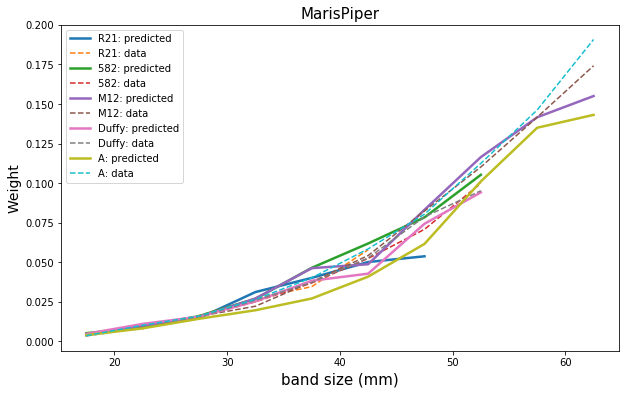

In [1305]:
def plot_tuberweight(summary, variety, field):
    df = pd.DataFrame(summary)
    bandsize = df['MidBand'].loc[:].values
    pred_tuberweight = df['Predicted Weight'].loc[:].values/df['Predicted Counts'].loc[:].values
    true_tuberweight = df['True Weight'].loc[:].values/df['True Counts'].loc[:].values

    plt.plot(bandsize, pred_tuberweight, lw=2.5, label=field+': predicted')
    plt.plot(bandsize, true_tuberweight, ls='dashed', label=field+': data')
    plt.title(variety, fontsize=15)

    

variety_ind = 0
field_ind = 0

variety = variety_names[variety_ind]
field = variety_dict[variety][field_ind]

fig1 = plt.figure(figsize=(10,6))
print('Variety:', variety )
for field in variety_dict[variety]:
        print('Field: ', field)
        predicted_df = knn_classifier(field,variety)
        summary, statistics_summary = give_summary(predicted_df)
        plot_tuberweight(summary, variety, field)
        print(summary)
        #print(summary.to_latex())
        file = open('Latex/summary_'+variety.replace(" ", "")+'_'+field.replace(" ", "")+'.tex','w') 
        file.write(statistics_summary.to_latex()+'\n'+summary.to_latex()+'\n') 
        file.close()

plt.xlabel('band size (mm)', fontsize=15)
plt.ylabel('Weight', fontsize=14)
plt.legend()
plt.show() 
fig1.savefig('figures/Tuberweight_plots_'+variety+'.pdf', bbox_inches='tight')




# Error

In [63]:
def error_plot(field, variety):

    error=[]
    midsizebands_train_data, Tuberweight_train_data, midsizebands_test_data, Tuberweight_test_data = get_traning_testing_data(field,variety) 
    for i in range(1,40):
        
        knn = KNeighborsClassifier(n_neighbors=i)  
        
        knn.fit(midsizebands_train_data.reshape(-1,1), Tuberweight_train_data) 
        Tuberweight_pred_i = knn.predict(midsizebands_test_data.reshape(-1,1))
        #error.append(np.mean(Tuberweight_pred_i != Tuberweight_test_data))
        error.append(np.sum((Tuberweight_pred_i/(fact_toconvert_int*1000) - Tuberweight_test_data/(fact_toconvert_int*1000))**2/len(Tuberweight_test_data)))

    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12,6))
    plt.plot(range(1,40), error, color='red', linestyle='dashed', marker='o',
            markerfacecolor='blue', markersize=10)
    plt.title('Error Rate Vs k Value (used in KNN)'+ '$\qquad $Varierty: '+variety+'$\qquad$ Field: '+field, fontsize=14)
    plt.xlabel('K Value', fontsize=14)
    plt.ylabel('Mean Error', fontsize=14)
    plt.show()

    fig.savefig('figures/error_k_value_'+variety+'_'+field+'.pdf', bbox_inches='tight')

  

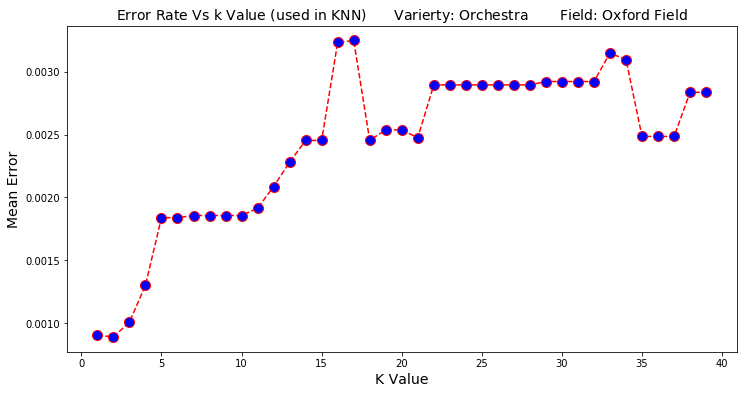

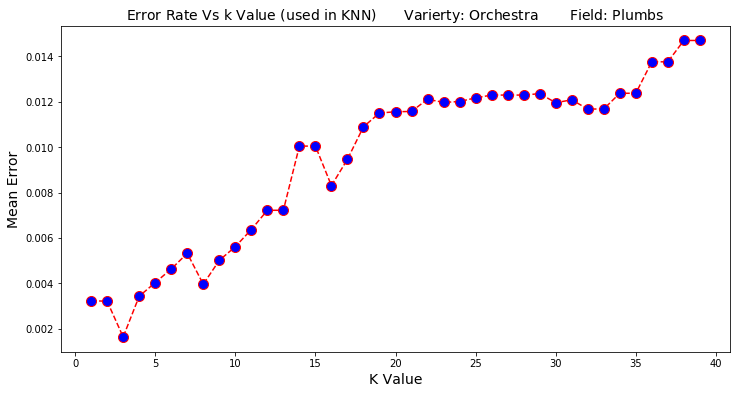

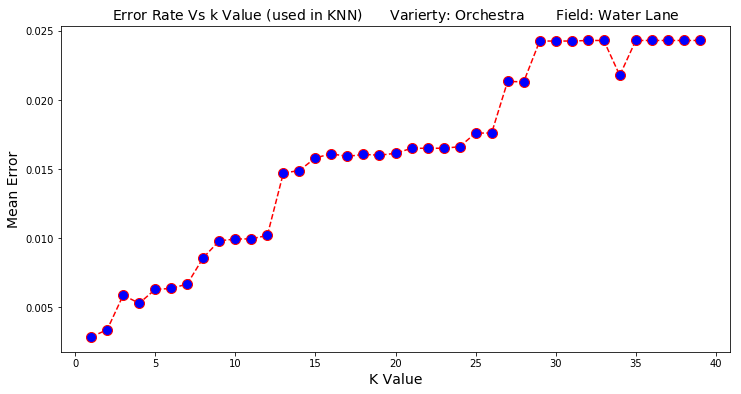

In [71]:
variety_ind = 7
variety = variety_names[variety_ind]
  
for field in variety_dict[variety]:
    error_plot(field, variety) 